In [1]:
from functools import partial
import sharding_utils

Calculating resources for sharding schemes...

--- Scheme: DP=8 ---
Total GFlops = 0.029360128
Activation memory (GB): 0.000114688
Weights memory (GB): 0.001835008
Output memory (GB): 4.096e-06
Output memory (GB) after additional axes gathers: 3.2768e-05
Total memory (GB): 0.001982464
Per-TPU comms for axis D all-gather (GB): 4.096e-06
Workload stats:

{   'memory_per_TPU_bytes': np.float64(1982464.0),
    't_comms': 7e-06,
    't_flops': np.float64(1.4903618274111675e-07)}

--- Scheme: sK=8 (Row-Parallel Weights) ---
Total GFlops = 0.029360128
Total GFlops after activation all-gather = 0.234881024
Activation memory (GB): 0.000114688
Weights memory (GB): 0.001835008
Activation memory (GB) after all-gather: 0.000917504
Output memory (GB): 3.2768e-05
Output memory (GB) after additional axes gathers: 3.2768e-05
Total memory (GB): 0.00278528
Per-TPU comms for activation all-gather (GB): 0.000114688
Workload stats:

{   'memory_per_TPU_bytes': np.float64(2785280.0),
    't_comms': np.float6

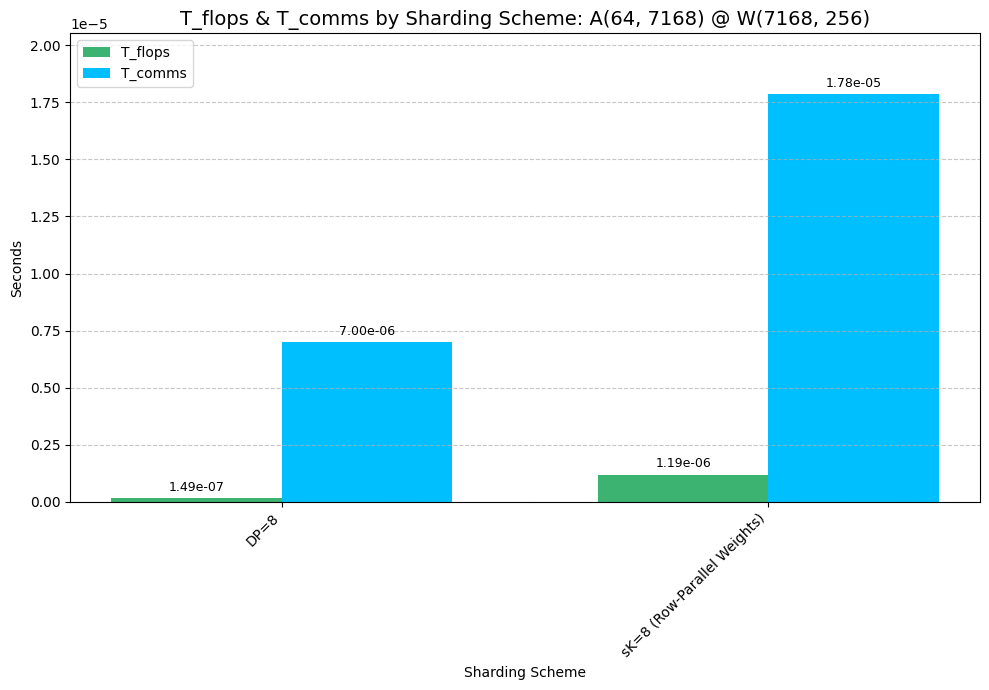

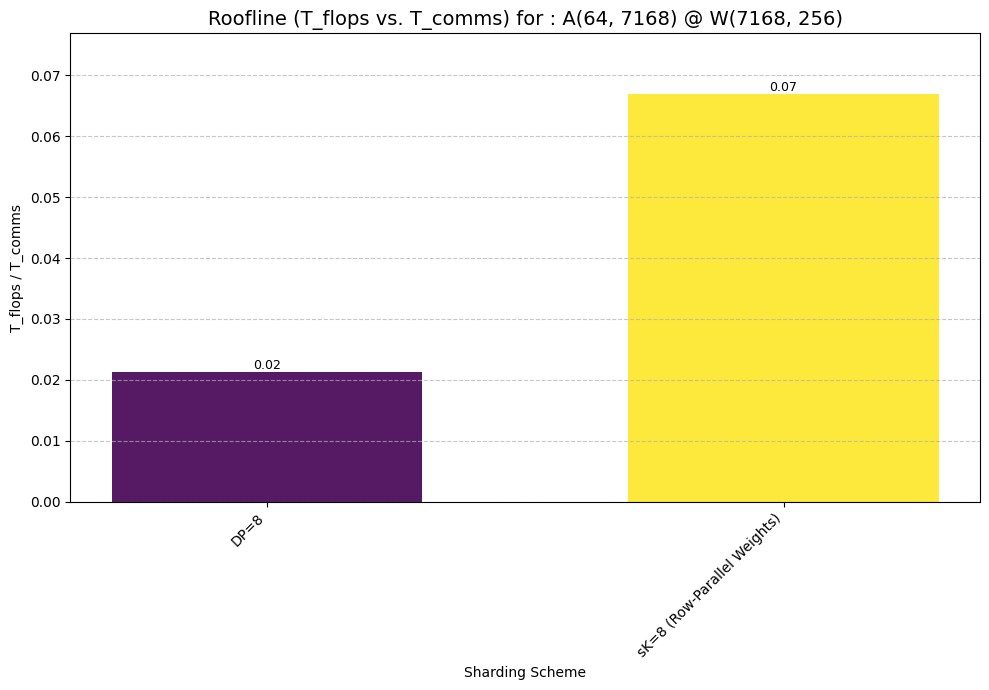

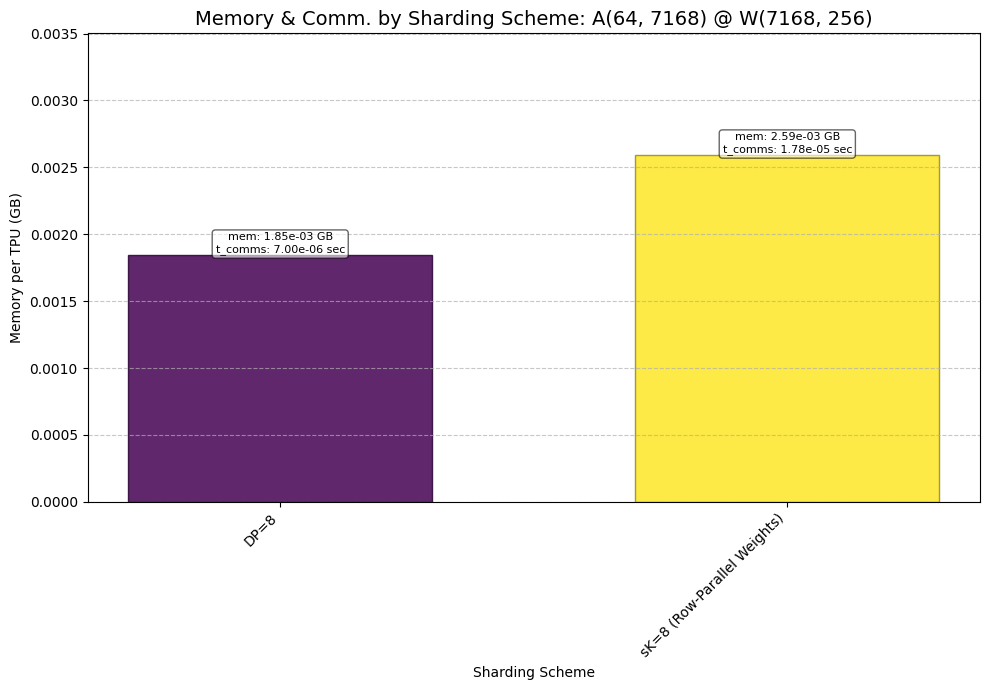

In [2]:
sharding_types = ["dW", "dK", "dW", "dF", "dE"]
sharding_amounts = [1, 1, 1, 8, 1]# @param
shardings = {sharding_type:sharding_amount for (sharding_type, sharding_amount) in 
                zip(sharding_types, sharding_amounts)}
max_sharding_amount = 8 # @param
activations_shape = (64, 7168) # @param
weights_shape = (7168, 256) # @param
ici_latency=1e-6 # @param
activation_size_bytes=2 # @param
weight_size_bytes=1 # @param
ici_bandwidth = 4.50E+10 # @param
peak_flops = 1.97E+14 #@param

calculate_resources_func = partial(sharding_utils.calculate_matmul_resources,
                                   ici_bandwidth=ici_bandwidth,
                                   activation_size_bytes=activation_size_bytes,
                                   weight_size_bytes=weight_size_bytes,
                                   ici_latency=ici_latency,
                                   peak_flops=peak_flops)
sharding_configurations = [
    {
        "label": "DP=8", # Pure Data Parallelism
        "shard_settings": {
            "sD": 8,
            "all_gather_axes": ("D",)
        }
    },
    {
        "label": "sK=8 (Row-Parallel Weights)", # Tensor Parallelism on K
        "shard_settings": {
            "sK": 8, # -> all-gather expected
        }
    }
]

sharding_utils.plot_sharding_scheme_comparison(calculate_resources_func,
                                activations_shape,
                                weights_shape,
                                sharding_configurations)

# MoE Layer Plots

## MoE Gate

Calculating resources for sharding schemes...

--- Scheme: Activation FSDP ---
Total GFlops = 0.234881024
Total GFlops after activation all-gather = 1.879048192
Activation memory (GB): 0.000114688
Weights memory (GB): 0.014680064
Activation memory (GB) after all-gather: 0.000917504
Output memory (GB): 0.000262144
Output memory (GB) after additional axes gathers: 0.000262144
Total memory (GB): 0.015859712
Per-TPU comms for activation all-gather (GB): 0.000114688
Workload stats:

{   'memory_per_TPU_bytes': np.float64(15859712.0),
    't_comms': np.float64(1.7840355555555554e-05),
    't_flops': np.float64(9.538315695431472e-06)}

--- Scheme: Weight FSDP ---
Total GFlops = 0.234881024
Total GFlops after weights all-gather = 1.879048192
Activation memory (GB): 0.000917504
Weights memory (GB): 0.001835008
Weight memory (GB) after all-gather: 0.014680064
Output memory (GB): 0.000262144
Output memory (GB) after additional axes gathers: 0.000262144
Total memory (GB): 0.015859712
Per-TPU comms

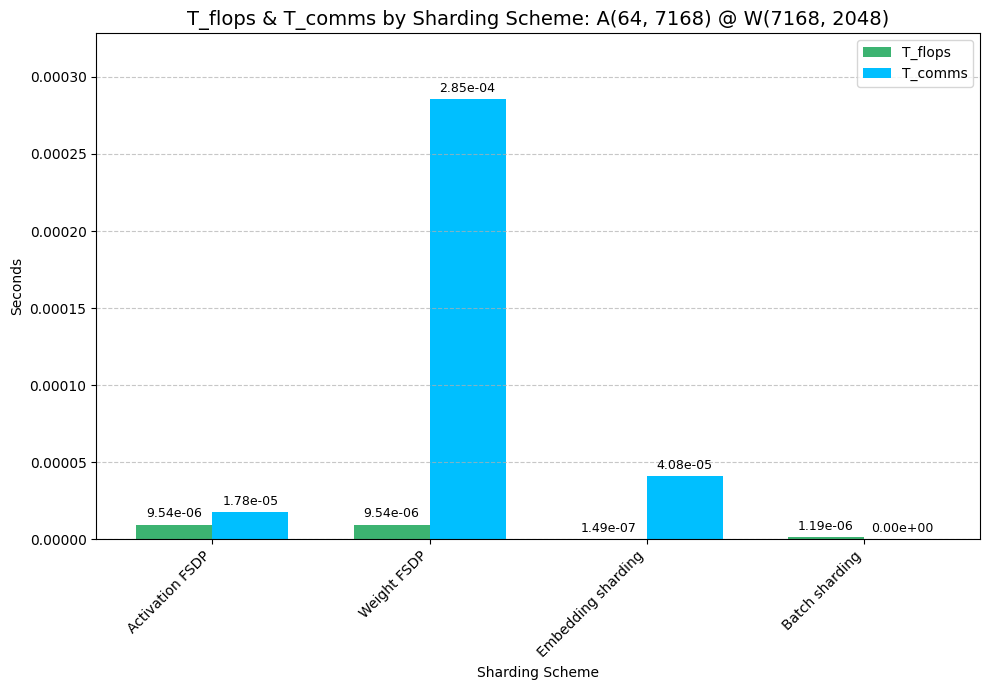

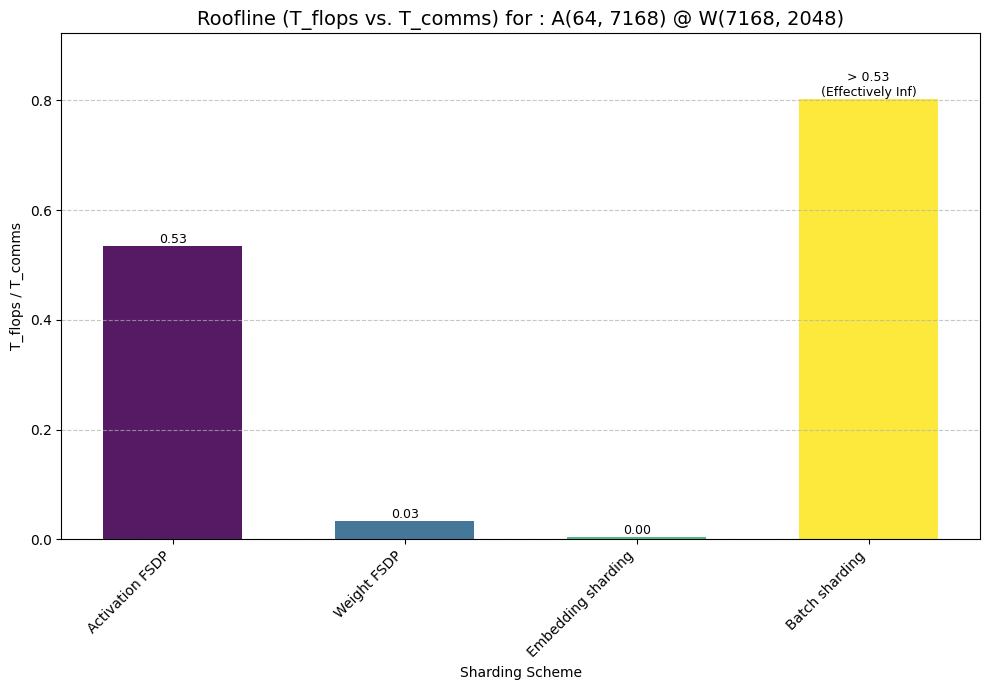

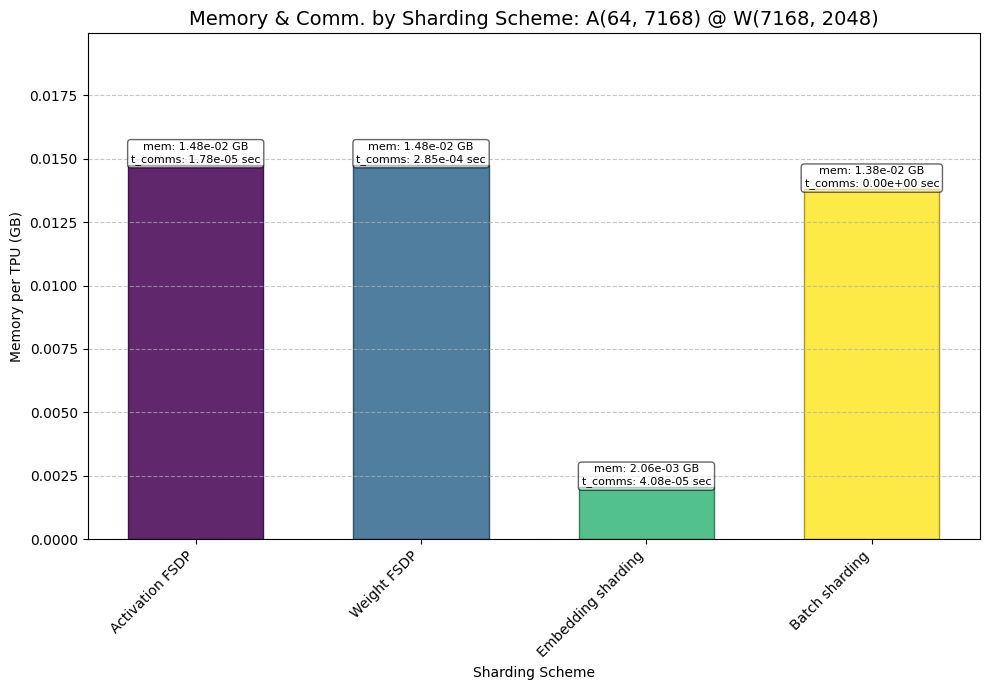

In [3]:
# MLP gate to generate expert scores (weight1).
activations_shape = (64, 7168) # @param
weights_shape = (7168, 2048) # @param
sharding_configurations = [
    {
        "label": "Activation FSDP",
        "shard_settings": {
            "sK": 8
        }
    },
    {
        "label": "Weight FSDP",
        "shard_settings": {
            "sW": 8
        }
        
    },
    {
        "label": "Embedding sharding",
        "shard_settings": {
            "sK": 8,
            "sW": 8
        }
        
    },
    {
        "label": "Batch sharding",
        "shard_settings": {
            "sD": 8
        }
        
    },

]
sharding_utils.plot_sharding_scheme_comparison(calculate_resources_func,
                                activations_shape,
                                weights_shape,
                                sharding_configurations)

Calculating resources for sharding schemes...

--- Scheme: Fully Replicated ---
Total GFlops = 0.234881024
Activation memory (GB): 0.000917504
Weights memory (GB): 0.001835008
Output memory (GB): 3.2768e-05
Output memory (GB) after additional axes gathers: 3.2768e-05
Total memory (GB): 0.00278528
Workload stats:

{   'memory_per_TPU_bytes': np.float64(2785280.0),
    't_comms': 0.0,
    't_flops': np.float64(1.192289461928934e-06)}

--- Scheme: Weight FSDP ---
Total GFlops = 0.029360128
Total GFlops after weights all-gather = 0.234881024
Activation memory (GB): 0.000917504
Weights memory (GB): 0.000229376
Weight memory (GB) after all-gather: 0.001835008
Output memory (GB): 3.2768e-05
Output memory (GB) after additional axes gathers: 3.2768e-05
Total memory (GB): 0.00278528
Per-TPU comms for weights all-gather (GB): 0.000229376
Workload stats:

{   'memory_per_TPU_bytes': np.float64(2785280.0),
    't_comms': np.float64(3.568071111111111e-05),
    't_flops': np.float64(1.192289461928934

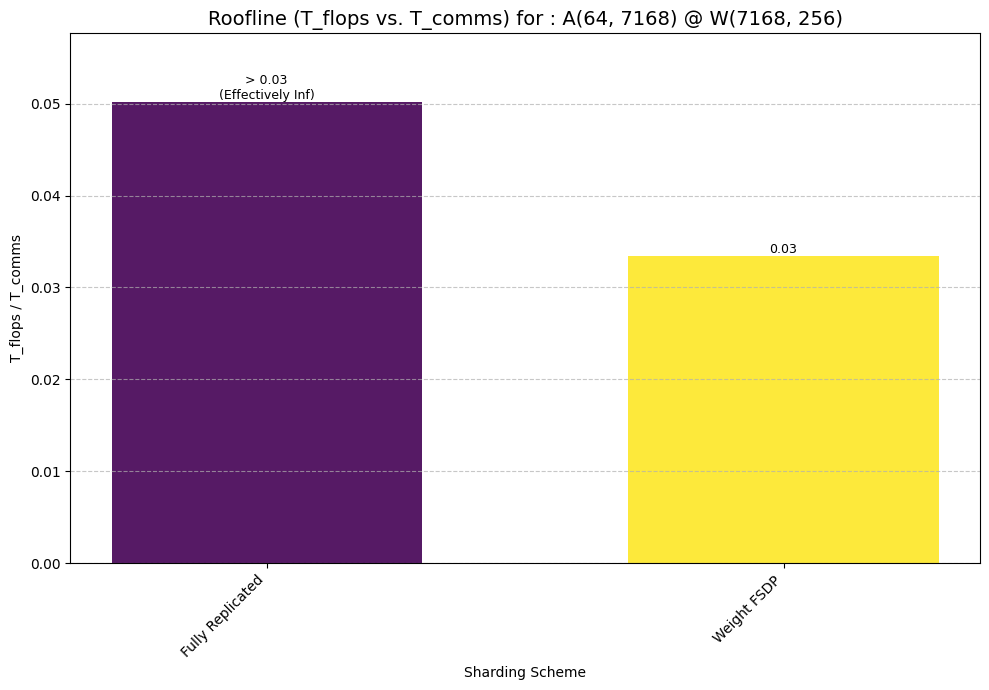

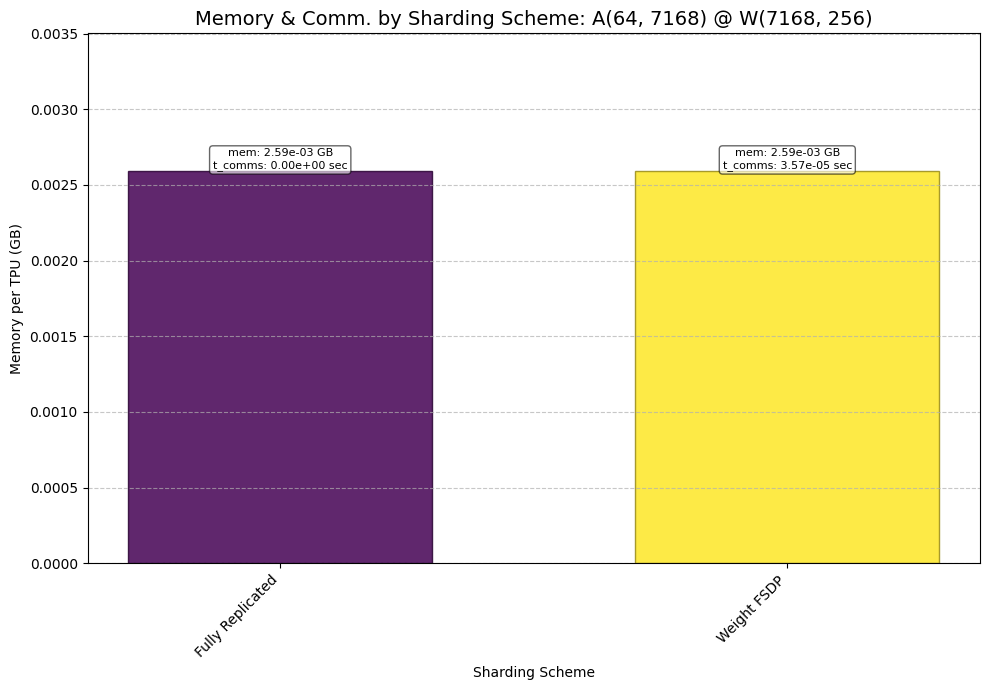

In [4]:
# MLP gate to generate expert scores (weight2).
activations_shape = (64, 7168) # @param
weights_shape = (7168, 256) # @param
sharding_configurations = [
    {
        "label": "Fully Replicated", # Pure Data Parallelism
        "shard_settings": {}
    },
    {
        "label": "Weight FSDP", # Pure Data Parallelism
        "shard_settings": {
            "sW": 8
        }
    },

]
sharding_utils.plot_sharding_scheme_comparison(calculate_resources_func,
                                activations_shape,
                                weights_shape,
                                sharding_configurations)